In [39]:
import numpy as np
import pandas as pd
import basedosdados as bd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, precision_score, recall_score, confusion_matrix, matthews_corrcoef, fbeta_score, brier_score_loss, precision_recall_curve, auc

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

## Dados

In [40]:
# TODO rode isto para criar o csv com vários hexágonos (O finalizado)
# main_table = bd.read_sql(query = """ SELECT * FROM `rj-cor-dev.clima_pluviometro.main_table_fields_1H_mais_frequentes`""", billing_project_id = 'projeto-fgv1', use_bqstorage_api = True)
# main_table.to_csv('csvs/main_table_mult_hexag.csv')

In [41]:
main_table_k = pd.read_csv("csvs/main_table.csv")

## Pré-processamento

In [42]:
main_table = main_table_k.copy()

In [43]:
main_table.fillna(0, inplace=True)

main_table['target'] = main_table['alagamento_pop'].apply(lambda x: 1 if x > 0 else 0)

main_table['id_h3'] = main_table['id_h3'].astype('category')

# Aplicar one-hot encoding na coluna 'estacao_ano'
one_hot_encoder = OneHotEncoder(sparse=False)
encoded_cols = one_hot_encoder.fit_transform(main_table[['estacao_ano']])
encoded_labels = one_hot_encoder.categories_[0]

# Adicionar as colunas codificadas ao DataFrame original
for i, label in enumerate(encoded_labels):
    main_table[f'estacao_ano_{label}'] = encoded_cols[:, i]


# Transformar a coluna id_h3 em categórica
label_encoder = LabelEncoder()
main_table['id_h3'] = label_encoder.fit_transform(main_table['id_h3'])


main_table.drop(columns=['data_hora', 'estacao_ano', 'alagamento_fim',
                         'estacoes', 'Unnamed: 0', 'alagamento_pop', 'alagamento_inicio', 
                         'quinzenas', 'alagamento_lat', 'alagamento_long', 'id_alagamento',
                         'gravidade_alagamento'], inplace=True)

In [44]:
X = main_table.drop(columns=['target'])
y = main_table['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

X_test

,id_h3,chuva_15min,chuva_1h,chuva_4h,chuva_24h,chuva_96h,estacao_ano_Inverno,estacao_ano_Outono,estacao_ano_Primavera,estacao_ano_Verão
67310,0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0
34323,0,0.0,0.0,0.000000,0.000000,2.800071,0.0,0.0,1.0,0.0
14363,0,0.0,0.0,2.199995,4.799952,7.399997,1.0,0.0,0.0,0.0
54341,0,0.0,0.0,0.000005,15.200427,15.800475,0.0,0.0,0.0,1.0
23676,0,0.0,0.0,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
10647,0,0.0,0.0,0.000000,0.000000,60.199665,0.0,0.0,0.0,1.0
48396,0,0.0,0.0,0.000000,0.200472,0.200472,1.0,0.0,0.0,0.0
26022,0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0
64259,0,0.0,0.0,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0


## Modelos

In [45]:
# Logistic Regression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred_lr = logreg.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred_lr))
print("R²: ", r2_score(y_test, y_pred_lr))
print("Error: ", mean_squared_error(y_test, y_pred_lr))
print("Precison: ", precision_score(y_test, y_pred_lr))
print("Recall: ", recall_score(y_test, y_pred_lr))
print("MCC: ", matthews_corrcoef(y_test, y_pred_lr))
print("Brier Score: ", brier_score_loss(y_test, y_pred_lr))
print("F-beta Score: ", fbeta_score(y_test, y_pred_lr, beta=0.5))

recall_lr, precision_lr, th_lr = precision_recall_curve(y_test, y_pred_lr)
print("Area under Precision Recall Curve: ", auc(recall_lr, precision_lr))

conf = confusion_matrix(y_test, y_pred_lr)
print("confusion matrix:\n", conf)

Accuracy:  0.9888462879051935
R²:  0.14101545253863135
Error:  0.011153712094806553
Precison:  0.7254901960784313
Recall:  0.24503311258278146
MCC:  0.4176597099319482
Brier Score:  0.011153712094806553
F-beta Score:  0.5211267605633803
Area under Precision Recall Curve:  0.4770706470109828
confusion matrix:
 [[11311    14]
 [  114    37]]


In [46]:
# KNN
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred_knn))
print("R²: ", r2_score(y_test, y_pred_knn))
print("Error: ", mean_squared_error(y_test, y_pred_knn))
print("Precison: ", precision_score(y_test, y_pred_knn, average='macro'))
print("Recall: ", recall_score(y_test, y_pred_knn, average='macro'))
print("MCC: ", matthews_corrcoef(y_test, y_pred_knn))
print("Brier Score: ", brier_score_loss(y_test, y_pred_knn))
print("F-beta Score: ", fbeta_score(y_test, y_pred_knn, beta=0.5))

recall_knn, precision_knn, th_knn = precision_recall_curve(y_test, y_pred_knn)
print("Area under Precision Recall Curve: ", auc(recall_knn, precision_knn))

conf = confusion_matrix(y_test, y_pred_knn)
print("confusion matrix binary:\n", conf)

Accuracy:  0.9905019170442663
R²:  0.26852097130242825
Error:  0.009498082955733705
Precison:  0.9150180593159505
Recall:  0.6717439293598234
MCC:  0.5339544260036041
Brier Score:  0.009498082955733705
F-beta Score:  0.6516290726817041
Area under Precision Recall Curve:  0.5826957240355749
confusion matrix binary:
 [[11315    10]
 [   99    52]]


In [47]:
# Neural Network

# 10 camadas ocultas com 10 neurônios cada relu
mlp = MLPClassifier(hidden_layer_sizes=(5,5), max_iter=1000, activation='relu', 
                    solver='adam', random_state=1, early_stopping=True)
mlp.fit(X_train, y_train)

y_pred_nn = mlp.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred_nn))
print("R²: ", r2_score(y_test, y_pred_nn))
print("Error: ", mean_squared_error(y_test, y_pred_nn))
print("Precison: ", precision_score(y_test, y_pred_nn))
print("Recall: ", recall_score(y_test, y_pred_nn))
print("MCC: ", matthews_corrcoef(y_test, y_pred_nn))
print("Brier Score: ", brier_score_loss(y_test, y_pred_nn))
print("F-beta Score: ", fbeta_score(y_test, y_pred_nn, beta=0.5))

recall_nn, precision_nn, th_nn = precision_recall_curve(y_test, y_pred_nn)
print("Area under Precision Recall Curve: ", auc(recall_nn, precision_nn))

conf = confusion_matrix(y_test, y_pred_nn)
print("confusion matrix:\n", conf)

Accuracy:  0.9884977344022308
R²:  0.11417218543046359
Error:  0.011502265597769257
Precison:  0.8518518518518519
Recall:  0.152317880794702
MCC:  0.3574247144340602
Brier Score:  0.011502265597769257
F-beta Score:  0.44401544401544407
Area under Precision Recall Curve:  0.49450382763383816
confusion matrix:
 [[11321     4]
 [  128    23]]


In [48]:
# Decision Tree

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred_dt))
print("R²: ", r2_score(y_test, y_pred_dt))
print("Error: ", mean_squared_error(y_test, y_pred_dt))
print("Precison: ", precision_score(y_test, y_pred_dt))
print("Recall: ", recall_score(y_test, y_pred_dt))
print("MCC: ", matthews_corrcoef(y_test, y_pred_dt))
print("Brier Score: ", brier_score_loss(y_test, y_pred_dt))
print("F-beta Score: ", fbeta_score(y_test, y_pred_dt, beta=0.5))

recall_dt, precision_dt, th_dt = precision_recall_curve(y_test, y_pred_dt)
print("Area under Precision Recall Curve: ", auc(recall_dt, precision_dt))

conf = confusion_matrix(y_test, y_pred_dt)
print("confusion matrix:\n", conf)

Accuracy:  0.987626350644824
R²:  0.0470640176600442
Error:  0.01237364935517602
Precison:  0.5290322580645161
Recall:  0.543046357615894
MCC:  0.5297248667146188
Brier Score:  0.01237364935517602
F-beta Score:  0.5317769130998704
Area under Precision Recall Curve:  0.5258876870664163
confusion matrix:
 [[11252    73]
 [   69    82]]


In [49]:
# Random Forest

rf = RandomForestClassifier(n_estimators=10, criterion='entropy')
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("R²: ", r2_score(y_test, y_pred_rf))
print("Error: ", mean_squared_error(y_test, y_pred_rf))
print("Precison: ", precision_score(y_test, y_pred_rf))
print("Recall: ", recall_score(y_test, y_pred_rf))
print("MCC: ", matthews_corrcoef(y_test, y_pred_rf))
print("Brier Score: ", brier_score_loss(y_test, y_pred_rf))
print("F-beta Score: ", fbeta_score(y_test, y_pred_rf, beta=0.5))

recall_rf, precision_rf, th_rf = precision_recall_curve(y_test, y_pred_rf)
print("Area under Precision Recall Curve: ", auc(recall_rf, precision_rf))

conf = confusion_matrix(y_test, y_pred_rf)
print("confusion matrix:\n", conf)

Accuracy:  0.9912861624259324
R²:  0.32891832229580575
Error:  0.00871383757406762
Precison:  0.8695652173913043
Recall:  0.3973509933774834
MCC:  0.5845237437940191
Brier Score:  0.00871383757406762
F-beta Score:  0.7025761124121779
Area under Precision Recall Curve:  0.6242650067437525
confusion matrix:
 [[11316     9]
 [   91    60]]


In [50]:
from sklearn.svm import SVC
svm = SVC()

svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred_svm))
print("R²: ", r2_score(y_test, y_pred_svm))
print("Error: ", mean_squared_error(y_test, y_pred_svm))
print("Precison: ", precision_score(y_test, y_pred_svm))
print("Recall: ", recall_score(y_test, y_pred_svm))
print("MCC: ", matthews_corrcoef(y_test, y_pred_svm))
print("Brier Score: ", brier_score_loss(y_test, y_pred_svm))
print("F-beta Score: ", fbeta_score(y_test, y_pred_svm, beta=0.5))

recall_svm, precision_svm, th_svm = precision_recall_curve(y_test, y_pred_svm)
print("Area under Precision Recall Curve: ", auc(recall_svm, precision_svm))

conf = confusion_matrix(y_test, y_pred_svm)
print("confusion matrix:\n", conf)


Accuracy:  0.9895433949111189
R²:  0.19470198675496697
Error:  0.010456605088881143
Precison:  0.8974358974358975
Recall:  0.23178807947019867
MCC:  0.45315630317054245
Brier Score:  0.010456605088881143
F-beta Score:  0.5700325732899023
Area under Precision Recall Curve:  0.5565081195091651
confusion matrix:
 [[11321     4]
 [  116    35]]


,chuva_15min,chuva_1h,chuva_4h,chuva_24h,chuva_96h,ds,estacao_ano_Inverno,estacao_ano_Outono,estacao_ano_Primavera,estacao_ano_Verão,y
0,0.0,0.0,0.0,0.600326,6.400151,2015-01-01 00:00:00,0.0,0.0,0.0,1.0,0
1,0.0,0.0,0.0,0.600326,6.400151,2015-01-01 01:00:00,0.0,0.0,0.0,1.0,0
2,0.0,0.0,0.0,0.600326,6.400151,2015-01-01 02:00:00,0.0,0.0,0.0,1.0,0
3,0.0,0.0,0.0,0.600326,6.400151,2015-01-01 03:00:00,0.0,0.0,0.0,1.0,0
4,0.0,0.0,0.0,0.600326,6.400151,2015-01-01 04:00:00,0.0,0.0,0.0,1.0,0


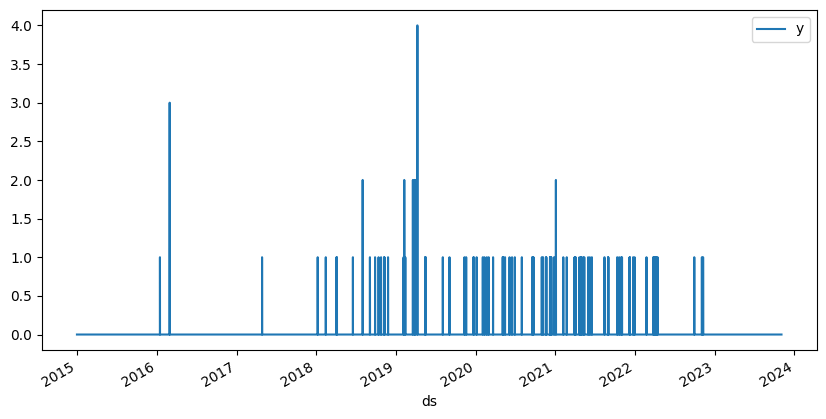

In [51]:
from neuralprophet import NeuralProphet, set_log_level, plot_forecast_matplotlib

df = pd.read_csv('csvs/main_table.csv')
df['data_hora'] = pd.to_datetime(df['data_hora'])
df['gravidade_alagamento'] = df['gravidade_alagamento'].replace('Baixo', 1)
df['gravidade_alagamento'] = df['gravidade_alagamento'].replace('Medio', 2)
df['gravidade_alagamento'] = df['gravidade_alagamento'].replace('Alto', 3)
df['gravidade_alagamento'] = df['gravidade_alagamento'].replace('Critico', 4)
df['gravidade_alagamento'] = df['gravidade_alagamento'].fillna(0)
df['gravidade_alagamento'] = df['gravidade_alagamento'].astype(int)

one_hot_encoder = OneHotEncoder(sparse=False)
encoded_cols = one_hot_encoder.fit_transform(df[['estacao_ano']])
encoded_labels = one_hot_encoder.categories_[0]

# Adicionar as colunas codificadas ao DataFrame original
for i, label in enumerate(encoded_labels):
    df[f'estacao_ano_{label}'] = encoded_cols[:, i]

df['y'] = df['gravidade_alagamento']

df.drop(columns=['id_h3', 'Unnamed: 0', 'estacao_ano', 'alagamento_fim',
                         'estacoes', 'alagamento_pop', 'alagamento_inicio', 'gravidade_alagamento', 
                         'quinzenas', 'alagamento_lat', 'alagamento_long', 'id_alagamento', ], inplace=True)

df = df.rename(columns={'data_hora': 'ds'})

plt = df.plot(x="ds", y="y", figsize=(10, 5))



# Select rows that have different values in the specified column
df.fillna(0, inplace=True)
df.drop_duplicates(subset=['ds'], keep='first', inplace=True)


df.head()

In [52]:

# Disable logging messages unless there is an error
set_log_level("ERROR")

# Create a NeuralProphet model with default parameters
m = NeuralProphet()
m.add_future_regressor('chuva_24h')
m.add_future_regressor('chuva_96h')
m.add_future_regressor('chuva_15min')
m.add_future_regressor('chuva_1h')
m.add_future_regressor('chuva_4h')
m.add_future_regressor('estacao_ano_Inverno')
m.add_future_regressor('estacao_ano_Outono')
m.add_future_regressor('estacao_ano_Primavera')
m.add_future_regressor('estacao_ano_Verão')

# Use static plotly in notebooks
m.set_plotting_backend("plotly-static")

# Fit the model on the dataset (this might take a bit)
metrics = m.fit(df)

forecast = m.predict(df)

fig = m.plot(forecast)
metrics

ValueError: The parameter `plotting_backend` must be either 'plotly', 'plotly-resampler' or 'matplotlib'.

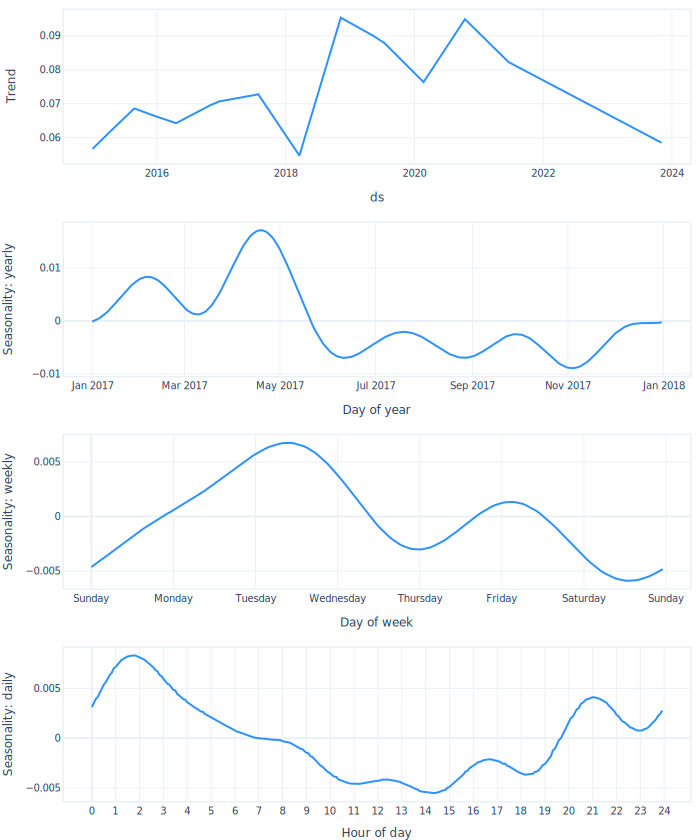

TypeError: plot() got an unexpected keyword argument 'line_per_origin'

In [ ]:
m.plot_parameters(components=["trend", "seasonality"])
m.plot(forecast,
   xlabel="ds",
   ylabel="y",
   line_per_origin=False,
   figsize=(10, 6)
   )